# Report 2: Computational Bayesian Statistics
## Taylor Sheneman

In [1]:
from __future__ import print_function, division

import numpy as np
import random

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, MakeBinomialPmf
import thinkplot

% matplotlib inline

## Problems from Think Bayes Chapter 4 and 5 Notes

Worked problems from Allen Downey's Think Bayes supplementary materials.

In [2]:
from scipy import special

class Beta:
    """Represents a Beta distribution.

    See http://en.wikipedia.org/wiki/Beta_distribution
    """
    def __init__(self, alpha=1, beta=1, label=None):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.label = label if label is not None else '_nolegend_'

    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails

    def Mean(self):
        """Computes the mean of this distribution."""
        return self.alpha / (self.alpha + self.beta)

    def MAP(self):
        """Computes the value with maximum a posteori probability."""
        a = self.alpha - 1
        b = self.beta - 1
        return a / (a + b)

    def Random(self):
        """Generates a random variate from this distribution."""
        return random.betavariate(self.alpha, self.beta)

    def Sample(self, n):
        """Generates a random sample from this distribution.

        n: int sample size
        """
        size = n,
        return np.random.beta(self.alpha, self.beta, size)

    def EvalPdf(self, x):
        """Evaluates the PDF at x."""
        return x ** (self.alpha - 1) * (1 - x) ** (self.beta - 1)

    def MakePmf(self, steps=101, label=None):
        """Returns a Pmf of this distribution.

        Note: Normally, we just evaluate the PDF at a sequence
        of points and treat the probability density as a probability
        mass.

        But if alpha or beta is less than one, we have to be
        more careful because the PDF goes to infinity at x=0
        and x=1.  In that case we evaluate the CDF and compute
        differences.

        The result is a little funny, because the values at 0 and 1
        are not symmetric.  Nevertheless, it is a reasonable discrete
        model of the continuous distribution, and behaves well as
        the number of values increases.
        """
        if label is None and self.label is not None:
            label = self.label

        if self.alpha < 1 or self.beta < 1:
            cdf = self.MakeCdf()
            pmf = cdf.MakePmf()
            return pmf

        xs = [i / (steps - 1) for i in range(steps)]
        probs = [self.EvalPdf(x) for x in xs]
        pmf = Pmf(dict(zip(xs, probs)), label=label)
        return pmf

    def MakeCdf(self, steps=101):
        """Returns the CDF of this distribution."""
        xs = [i / (steps - 1) for i in range(steps)]
        ps = special.betainc(self.alpha, self.beta, xs)
        cdf = Cdf(xs, ps)
        return cdf

    def Percentile(self, ps):
        """Returns the given percentiles from this distribution.

        ps: scalar, array, or list of [0-100]
        """
        ps = np.asarray(ps) / 100
        xs = special.betaincinv(self.alpha, self.beta, ps)
        return xs


### Euro Problem (with Beta distributions!)

One way to construct priors is to make a Beta distribution and adjust the parameters until it has the shape you want.  Then when you do an update, the data get added to the parameters of the prior.  Since the parameters of the prior play the same mathematical role as the data, they are sometimes called "precounts".

Suppose you believe that most coins are fair or unlikely to deviate from 50% by more than a few percentage points.  Construct a prior that captures this belief and update it with the Euro data.  How much effect does it have on the posterior, compared to the uniform prior?

Hint: A Beta distribution with parameters `(1, 1)` is uniform from 0 to 1.

uniform prior posterior mean: 0.559523809524
beta(50,50) prior posterior mean: 0.542857142857
beta(100,100) prior posterior mean: 0.533333333333


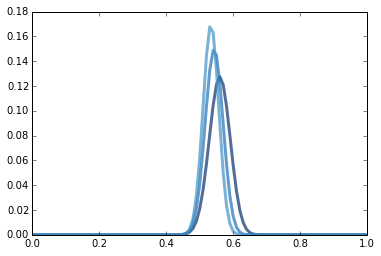

In [3]:
beta = Beta()
beta.Update((140, 110))
print("uniform prior posterior mean:",beta.Mean())

beta2 = Beta(50,50)
beta2.Update((140, 110))
print("beta(50,50) prior posterior mean:",beta2.Mean())

beta3 = Beta(100,100)
beta3.Update((140, 110))
print("beta(100,100) prior posterior mean:",beta3.Mean())

thinkplot.Pdf(beta.MakePmf())
thinkplot.Pdf(beta2.MakePmf())
thinkplot.Pdf(beta3.MakePmf())

The stronger the belief reflected in the prior, the higher the "precount" values, and the less readily the distribution is modified by data. The beta(100,100) posterior is only a couple percentage points different from the result of a uniform prior when updated with 250 points, though.

### Kim Rhode problem

At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match.  They each hit 15 of 25 skeets, sending the match into sudden death.  In the first round, both hit 1 of 2 skeets.  In the next two rounds, they each hit 2 skeets.  Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei?  If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet.  Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them.  To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

Kim Rhode (uniform prior) posterior mean: 0.657142857143
Wei Meng (uniform prior) posterior mean: 0.628571428571


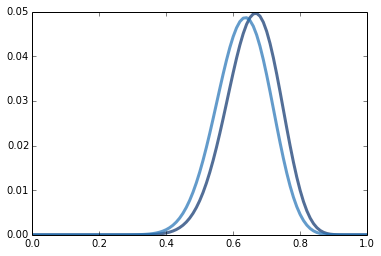

In [4]:
rhode_beta = Beta()
rhode_beta.Update((15,10))
rhode_beta.Update((1,1))
rhode_beta.Update((2,0))
rhode_beta.Update((2,0))
rhode_beta.Update((2,0))
print("Kim Rhode (uniform prior) posterior mean:",rhode_beta.Mean())

wei_beta = Beta()
wei_beta.Update((21,12))
print("Wei Meng (uniform prior) posterior mean:",wei_beta.Mean())

thinkplot.Pdf(rhode_beta.MakePmf())
thinkplot.Pdf(wei_beta.MakePmf())

Kim Rhode (beta(3,2) prior) posterior mean: 0.657894736842
Wei Meng (beta(3,2) prior) posterior mean: 0.631578947368


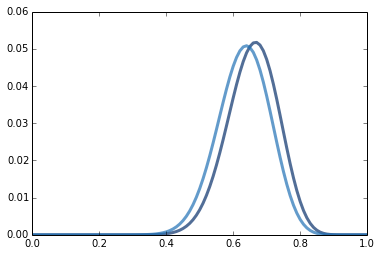

In [5]:
rhode_beta2 = Beta(3,2)
rhode_beta2.Update((22,11))
print("Kim Rhode (beta(3,2) prior) posterior mean:",rhode_beta2.Mean())

wei_beta2 = Beta(3,2)
wei_beta2.Update((21,12))
print("Wei Meng (beta(3,2) prior) posterior mean:",wei_beta2.Mean())

thinkplot.Pdf(rhode_beta2.MakePmf())
thinkplot.Pdf(wei_beta2.MakePmf())

When the prior is beta(3,2) instead of uniform, the model gives a lower difference in predicted success rate between the two shooters.

In [6]:
num_samples = 5000
total = 0

for i in range(num_samples):
    r = rhode_beta2.Random()
    w = wei_beta2.Random()
    if r > w:
        total += 1

print(total/num_samples)

0.588


In 5000 random draws, Kim Rhode's score is higher than Wei Meng's around 59% of the time.

A simulated match:

In [7]:
num_shots = 25
total_r = 0
total_w = 0

r = rhode_beta2.Random()
w = wei_beta2.Random()

for i in range(num_shots):
    if random.random() < r:
        total_r += 1
    if random.random() < w:
        total_w += 1

print(total_r,total_w)

17 17


A simulated 5000 matches, with percentages of wins, losses and ties.

In [8]:
matches = 5000
shots = 25
total_wins = 0
total_losses = 0
total_ties = 0

for i in range(matches):
    total_r = 0
    total_w = 0

    r = rhode_beta2.Random()
    w = wei_beta2.Random()

    for j in range(shots):
        if random.random() < r:
            total_r += 1
        if random.random() < w:
            total_w += 1

    if total_r > total_w:
        total_wins += 1
    elif total_r < total_w:
        total_losses += 1
    else:
        total_ties += 1

print("Win %:", total_wins/matches)
print("Loss %:", total_losses/matches)
print("Tie %:", total_ties/matches)

Win %: 0.507
Loss %: 0.4012
Tie %: 0.0918


Kim Rhode seems to win around 51% and lose around 39% of the time in 5000 simulated matches of 25 shots. Of course, the 8 or 9% tie rate would translate into longer matches until the tie is broken, but that would require some tricky conditionals and probably work out to around the same win:loss rate.

### Euro Problem (with bad measurements!)

Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability `y` that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of `y`.

How does the spread of the posterior distribution depend on `y`?

(Not sure I actually need a class here. A function works on its own.)

post mean w/ p(incorrect reading) 0 : 0.55859375
post mean w/ p(incorrect reading) 0.25 : 0.529296875
post mean w/ p(incorrect reading) 0.5 : 0.5
post mean w/ p(incorrect reading) 0.75 : 0.470703125
post mean w/ p(incorrect reading) 1 : 0.44140625


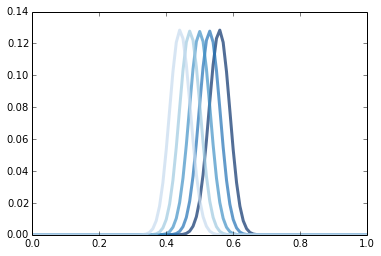

In [9]:
def estimate_bias(heads,tails,y):
    """Given number of heads and tails flipped, and the probability
    of an incorrect measurement y, returns the mean of a distribution
    of the coin's probable bias."""
    beta = Beta(3,3)
    beta.Update((heads + (tails-heads)*y, tails + (heads-tails)*y))
    thinkplot.Pdf(beta.MakePmf())
    return beta.Mean()

print("post mean w/ p(incorrect reading)",0,":",
      estimate_bias(140,110,0))
print("post mean w/ p(incorrect reading)",0.25,":",
      estimate_bias(140,110,0.25))
print("post mean w/ p(incorrect reading)",0.5,":",
      estimate_bias(140,110,0.5))
print("post mean w/ p(incorrect reading)",0.75,":",
      estimate_bias(140,110,0.75))
print("post mean w/ p(incorrect reading)",1,":",
      estimate_bias(140,110,1))

Interesting note: when the probability of an incorrect measurement is 50%, you can no longer learn anything about the coin's bias from using it.

### Cat Party Problem

Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats.  Because you have cats, you expect 50% of the allergic guests to sneeze during dinner.  At the same time, you expect 10% of the non-allergic guests to sneeze.  What is the distribution of the total number of guests who sneeze?

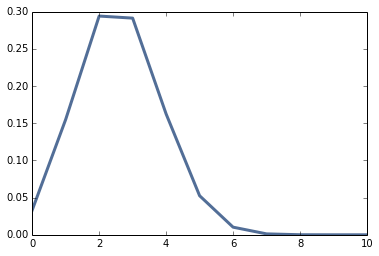

In [10]:
allergic = MakeBinomialPmf(n=4, p=0.5)
nonallergic = MakeBinomialPmf(n=6, p=0.1)

total_pmf = Pmf()
for v1, p1 in allergic.Items():
    for v2, p2 in nonallergic.Items():
        total_pmf[v1 + v2] += p1 * p2


thinkplot.Pdf(total_pmf)

### Chess Problem

Two identical twins are members of my chess club, but they never show up on the same day; in fact, they strictly alternate the days they show up.  I can't tell them apart except that one is a better player than the other:  Avery beats me 60% of the time and I beat Blake 70% of the time.  If I play one twin on Monday and win, and the other twin on Tuesday and lose, which twin did I play on which day?

In [13]:
chess = Pmf(['hypoAB', 'hypoBA'])
chess['hypoAB'] *= .4
chess['hypoBA'] *= .7
chess['hypoAB'] *= .3
chess['hypoBA'] *= .6
chess.Normalize()
chess.Print()

hypoAB 0.222222222222
hypoBA 0.777777777778


## Another Bayes Problem

### Snowy Winter Problem

The winter of 2014-2015 is sometimes referred to as the "snowpocalypse", due to record snowfall numbers in much of the country, particularly the East Coast. The snow here in Boston attracted a particularly large amount of media attention (as far as I remember, as a Chicagoan). The snow was definitely unusual, but was it an unusually cold winter? As it turns out, in December 2014-February 2015, there were 35 days that never reached freezing temperature (from below), compared to the previous year, in which there were 37 such days in the same period. What is the probability that this happened due to an actual overall temperature shift, rather than random variation?

In [22]:
def ProbGreater(pmf1, pmf2):
    """Enumerates all possible combinations of entries from pmf1 and
    pmf2 and totals the probabilities of the ones that result in a
    greater entry from pmf1. Taken straight from the notes."""
    total = 0
    for x1, prob1 in pmf1.Items():
        for x2, prob2 in pmf2.Items():
            if x1 > x2:
                total += prob1 * prob2
    return total

def ProbLess(pmf1, pmf2):
    """Same as above, except less."""
    total = 0
    for x1, prob1 in pmf1.Items():
        for x2, prob2 in pmf2.Items():
            if x1 < x2:
                total += prob1 * prob2
    return total

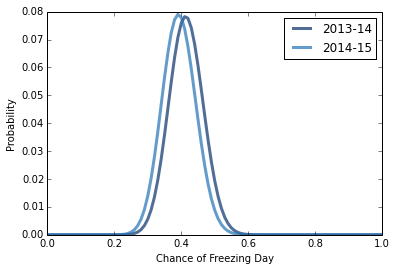

In [20]:
winter2015 = Beta(2, 2, label='2014-15')
winter2015.Update((35, 55))
winter2014 = Beta(2, 2, label='2013-14')
winter2014.Update((37, 53))

thinkplot.Pdf(winter2014.MakePmf())
thinkplot.Pdf(winter2015.MakePmf())
thinkplot.Config(xlabel='Chance of Freezing Day', ylabel='Probability')

In [27]:
pmf1 = winter2015.MakePmf(1001)
pmf2 = winter2014.MakePmf(1001)
print("Probability that 2015 is warmer than 2014:",ProbLess(pmf1,pmf2))

Probability that 2015 is warmer than 2014: 0.614781671115


There seems to be some weak evidence that the snowpocalypse was actually warmer than the previous winter.

This example is a bit contrived, I know. I worked through a bunch of ideas having to do with temperatures, but I wanted more practice with beta distributions and probability of superiority.